#Implementación de un modelo de Deep Learning

#Introducción

El presente trabajo aborda la clasificación automática de escenas naturales mediante técnicas de aprednizaje profundo (_deep learning_). El problema busca que el modelo identifique el entorno representado en una imagen—como un bosque o el mar— a partir de patrones visuales complejo. La clasificación de escenas es una tarea fundamental en áreas como análisis geográfico y gestión ambiental, así como la construcción de grandes bases de imágenes digitales. Correspondientemente, representa un desafío dado que el modelo debe reconocer estructuras, texturas y diferentes patrones en condiciones diversas.

Para el desarrollo se utilizó el dataset Intel Image Classification de Kaggle (Apéndice 1). Éste contiene seis categorías correspondientes a: _buildings_, _forest_, _glacier_, _mountain_, _sea_ y _street_. Las imágenes contienen una amplia variabilidad visual, incluyendo fondos, perspectivas y condiciones de iluminación. Por lo tanto, el datatset es adecuado para analizar el rendimiento de diferentes modelos de _deep learning_.

El presente trabajo tiene como objetivo implementar un modelo de _deep learning_ para clasificar escenas natirales y evaluar su desempeño con diferentes arquitecturas. En una primera iteración, se desarrolla un modelo base para establecer un punto de referencia inicial. Posteriormente, se implementa una segunda versión ajustada, incorporando técnicas de regularización y _data augmentation_ con el propósito de reducir el sobreajuste y mejorar la precisión de validación. De esta manera, se busca comparar el efecto de los ajustes en la capacidad del modelo para generalizar ante imágenes nuevas.

#Datos
Para el procesamiento, las imágenes fueron organizadas en tres subconjuntos: entrenamiento, validación y prueba. El conjunto de entrenamiento se utilizó para ajustar los parámetros internos del modelo, mientras que el de validación permitió supervisar su rendimiento durante las épocas de entrenamiento y prevenir el sobreajuste. Finalmente, el conjunto de prueba se reservó para la evaluación final del modelo.

El preprocesamiento de las imágenes incluyó su redimensionamiento a una resolución uniforme de 150×150 píxeles y la normalización de sus valores de intensidad a un rango entre 0 y 1.Correspondientemente, las etiquetas asociadas a cada imagen fueron gestionadas por la función _image_dataset_from_directory()_ de Keras. Así, se asigna una categoría numérica a cada clase con base en la estructura de carpetas para mantener la correspondencia entre imágenes y etiquetas.

In [ ]:

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

# Downloand the Intel Image Classification dataset
# (Fuente: https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
!kaggle datasets download -d puneet6060/intel-image-classification

!unzip -q intel-image-classification.zip -d ./intel_dataset

!ls ./intel_dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 89% 307M/346M [00:00<00:00, 872MB/s] 
100% 346M/346M [00:00<00:00, 758MB/s]
seg_pred  seg_test  seg_train


In [ ]:
import os, pathlib, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE


train_dir = "./intel_dataset/seg_train/seg_train"
test_dir = "./intel_dataset/seg_test/seg_test"
pred_dir = "./intel_dataset/seg_pred/seg_pred"


train_data = image_dataset_from_directory(
    train_dir,
    validation_split=0.25,
    subset="training",
    seed=42,
    image_size=(150, 150),
    batch_size=32
)

val_data = image_dataset_from_directory(
    train_dir,
    validation_split=0.25,
    subset="validation",
    seed=42,
    image_size=(150, 150),
    batch_size=32
)


test_data = image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=32
)

class_names= train_data.class_names
print("Classes:", class_names)



Found 14034 files belonging to 6 classes.
Using 10526 files for training.
Found 14034 files belonging to 6 classes.
Using 3508 files for validation.
Found 3000 files belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


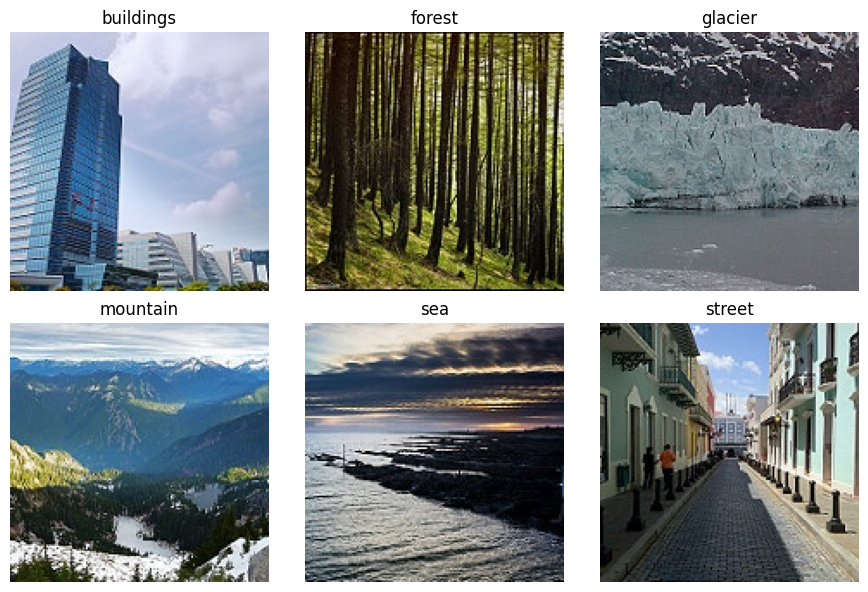

In [ ]:
#Visualize one image per class

plt.figure(figsize=(9, 6))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    img = plt.imread(os.path.join(class_path, os.listdir(class_path)[1]))
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

#Modelo base de Deep learning

El modelo desarrollado en la primera iteración corresponde a una red neuronal convolucional (CNN) para la clasificación del dataset. La arquitectura se compone de tres bloques convolucionales seguidos de operaciones de _max pooling_, una capa de aplanamiento y y dos capas densas. . La estructura permite que el modelo extraiga las características visuales más relevantes de las imágenes. La función de activación utilzada en las capas convolucionales y densas es _ReLU_, y la capa de salida emplea _softmax_ dado que es un problema de clasificación múltiple.

Para favorecer la generalización del modelo, se integró una capa de _data augmentation_ al inicio de la arquitectura. La capa aplica transformaciones aleatorias sobre las imágenes de entrada para generar variaciones artificiales en el dataset de entrenamiento y evitar la memorización. En conjunto con la normalización de píxeles, ambas técnicas contribuyen a estabilizar el aprendizaje del modelo.

El modelo fue entrenado con el optimizador Adam, utilizando un _learning rate_ de 1x10e-4 para tener una convergencia más controlada. Además, se incorporó una capa de _Dropout_ con una tasa del 30 % después de la capa densa intermedia. Esto con el propósito de reducir la dependencia del modelo hacia neuronas específica.

La función de pérdida seleccionada fue _sparse categorical crossentropy_, adecuada para etiquetas enteras que representan las seis clases del conjunto de datos.

In [ ]:
#Data aughmentation
data_augmentation= keras.Sequential([
    layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

#First instance for the deep learning model
model_base= keras.Sequential([
    keras.Input(shape=(150,150,3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32,3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3, activation= 'relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128,3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')]
)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model_base.compile(optimizer=optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_base.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Durante el entrenamiento se emplearon los callbacks _ModelCheckpoint_ y _EarlyStopping_. Éstas permiten guardar automáticamente la mejor versión del modelo y detener el entrenamiento cuando la precisión de validación deja de mejorar. Esta configuración tiene como propósito evitar el sobreajuste conservando los mejores pesos obtenidos.

In [ ]:
#Training the model
callbacks_base = [
    keras.callbacks.ModelCheckpoint("../models/intel_baseline.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history_base = model_base.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks_base
)

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.4222 - loss: 1.4228 - val_accuracy: 0.5818 - val_loss: 1.1680
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6179 - loss: 1.0234 - val_accuracy: 0.6023 - val_loss: 1.1161
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6484 - loss: 0.9334 - val_accuracy: 0.6633 - val_loss: 0.9422
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.6690 - loss: 0.8965 - val_accuracy: 0.6890 - val_loss: 0.8516
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.6982 - loss: 0.8292 - val_accuracy: 0.7044 - val_loss: 0.8349
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.7200 - loss: 0.7873 - val_accuracy: 0.7235 - val_loss: 0.7701
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7187 - loss: 0.7771 - val_accuracy: 0.7178 - val_loss: 0.7903
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7292 - loss: 0.7384 - 

# Evaluación del modelo base

Posteriormente, se graficaron las curvas de pérdida y precisión correspondientes al entrenamiento y validación del modelo.


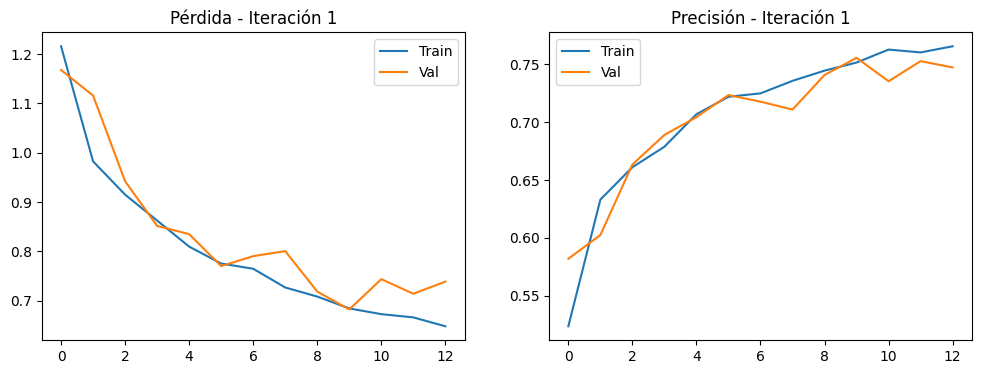

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_base.history['loss'], label='Train')
plt.plot(history_base.history['val_loss'], label='Val')
plt.title('Pérdida - Iteración 1')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_base.history['accuracy'], label='Train')
plt.plot(history_base.history['val_accuracy'], label='Val')
plt.title('Precisión - Iteración 1')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_base.evaluate(test_data)
print(f" Pérdida en test: {test_loss:.4f}")
print(f" Precisión en test: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7663 - loss: 0.6630
 Pérdida en test: 0.6854
 Precisión en test: 0.7600


El entrenamiento del modelo mostró un compartamiento de convergencia estable a lo largo de las épocas. En la gráfica de pérdida (_loss_), se observa una disminución continúa en los subconjuntos de _training_ y _validation_. Esto indica que el modelo logra reducir el error progresivamente. La curva de validación presenta valores ligeramente superiores a los de entrenamiento. Sin embargo, ambas curvas mantienen una tendencia descendiente similar, lo que sugiere que el modelo no incurrió en un sobreajuste severo.

Por su parte, la gráfica de precisión (_accuracy_) se aprecua un incremento sostenido con valores cercanos al 78% para entrenamiento y entre 74-76% para validación. La separación entre las curvas evidencia un sobreajuste moderado, propio de modelos que aprenden con mayor detalle los patrones del conjunto de entrenamiento. Este comportamiento puede atribuirse a la complejidad visual del dataset y a la ausencia de técnicas adicionales de regularización. No obstante, las tendencias son consistentes.

En conjunto, el modelo alcanzó un desempeño estable y coherente con la arquitectura propuesta.Las curvas obtenidas confirman que la red convolucional fue capaz de identificar patrones relevantes en las imágenes y generalizar con un nivel de precisión satisfactorio, estableciendo una base sólida para la siguiente etapa de ajuste y mejora del modelo.

Correspondientemente, se utilizó el conjunto de datos de evaluación para medir el rendimiento final del modelo sobre imágenes no vistas durante el entrenamiento.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


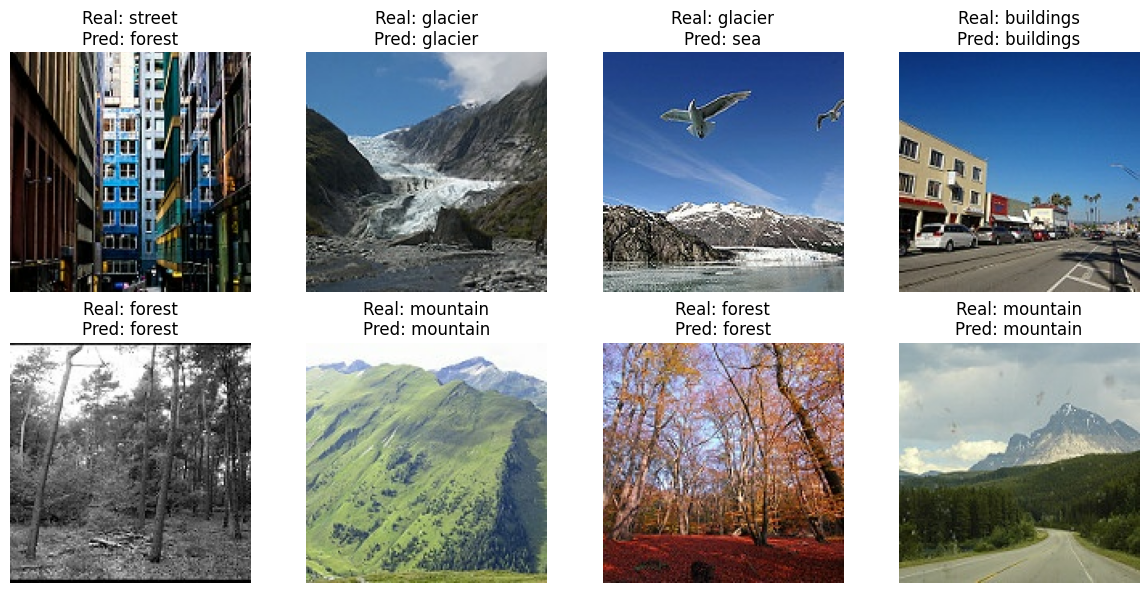

In [ ]:
# Using the test dataset to evaluate the model in one of the batches

for images, labels in test_data.take(1):
    preds = model_base.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = test_data.class_names[labels[i]]
        pred_label = test_data.class_names[pred_classes[i]]
        plt.title(f"Real: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Al evaluar el modelo sobre el conjunto de prueba, se observó que las predicciones fueron en su mayoría correctas. No obstante, existen algunos casos de confusión en imágenes con composición visual compleja. En particular, el modelo tiende a clasificar erróneamente aquellas escenas que contienen elementos característicos de más de una categoría, como montañas con áreas boscosas o construcciones cercanas al mar. Este comportamiento es esperable, ya que la red convolucional empleada se basa en la detección de patrones visuales dominantes. Es decir, carece de mecanismos de comprensión contextual. Aun así, el modelo muestra una capacidad adecuada para reconocer la clase principal en la mayoría de los casos.

In [ ]:
#Save the model just in case
model_base.save("models/model_base.keras")


#Modelo ajustado

In [ ]:
train_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_train/seg_train",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_train/seg_train",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

test_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_test/seg_test",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [ ]:
from tensorflow import keras
from keras import layers

data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
], name="data_augmentation")


model_2 = keras.Sequential([
    keras.Input(shape=(224, 224, 3)),
    data_aug,
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(6, activation='softmax')
])


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model_2.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()



Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,829,318 (37.50 MB)

 Trainable params: 9,828,358 (37.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
callbacks_adjusted2 = [
    keras.callbacks.ModelCheckpoint("../models/intel_model_iteration2.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history_adjusted2 = model_2.fit(
    train_dt,
    validation_data=val_dt,
    epochs=25,
    callbacks=callbacks_adjusted2
)


Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - accuracy: 0.5035 - loss: 1.7140 - val_accuracy: 0.3068 - val_loss: 2.6183
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 138ms/step - accuracy: 0.6107 - loss: 1.0473 - val_accuracy: 0.6996 - val_loss: 0.8179
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - accuracy: 0.6446 - loss: 0.9828 - val_accuracy: 0.7256 - val_loss: 0.7263
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 133ms/step - accuracy: 0.6663 - loss: 0.9194 - val_accuracy: 0.7498 - val_loss: 0.6858
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.7025 - loss: 0.8335 - val_accuracy: 0.7498 - val_loss: 0.6953
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 129ms/step - accuracy: 0.7106 - loss: 0.8133 - val_accuracy: 0.7391 - val_loss: 0.7946
Epoch 7/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.7263 - loss: 0.7845 - val_accuracy: 0.7808 - val_loss: 0.6159
Epoch 8/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.7303 - loss: 0

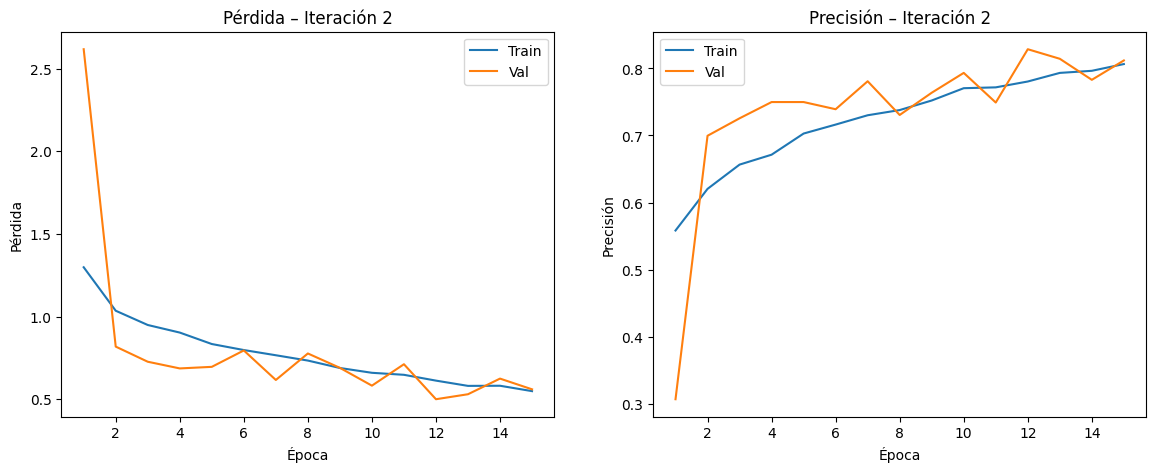

In [ ]:
import matplotlib.pyplot as plt

acc = history_adjusted2.history['accuracy']
val_acc = history_adjusted2.history['val_accuracy']
loss = history_adjusted2.history['loss']
val_loss = history_adjusted2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Train')
plt.plot(epochs, val_loss, label='Val')
plt.title('Pérdida – Iteración 2')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc,  label='Train')
plt.plot(epochs, val_acc, label='Val')
plt.title('Precisión – Iteración 2')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_2.evaluate(test_dt)
print(f" Pérdida en test: {test_loss:.4f}")
print(f" Precisión en test: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8344 - loss: 0.4780
 Pérdida en test: 0.4958
 Precisión en test: 0.8283


In [ ]:
model_adjusted.save("better_final_here_we_go_again.keras")